# Setup

In [1]:
!git clone https://github.com/IgnacioOQ/vaccine_ethics
%cd vaccine_ethics

Cloning into 'vaccine_ethics'...
remote: Enumerating objects: 130, done.
remote: Counting objects: 100% (130/130), done.
remote: Compressing objects: 100% (112/112), done.
remote: Total 130 (delta 70), reused 47 (delta 17), pack-reused 0 (from 0)
Receiving objects: 100% (130/130), 870.50 KiB | 22.91 MiB/s, done.
Resolving deltas: 100% (70/70), done.
/content/vaccine_ethics


In [2]:
from imports import *
from agent_class import FullAgent
from simulation_class import Simulation

In [3]:
!pip install scikit-optimize

from joblib import Parallel, delayed
from multiprocessing import cpu_count
from skopt import Optimizer
from skopt.space import Real
from skopt.plots import plot_convergence
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import plotly.express as px


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 7.8 MB/s eta 0:00:00


In [4]:
# Decide where to put the files and do the working
from google.colab import drive
drive.mount('/content/drive')

dump_path = '/content/drive/My Drive/Colab Projects/Vaccine Ethics/'
print("Current Directory:", dump_path)


Mounted at /content/drive
Current Directory: /content/drive/My Drive/Colab Projects/Vaccine Ethics/


# Testing

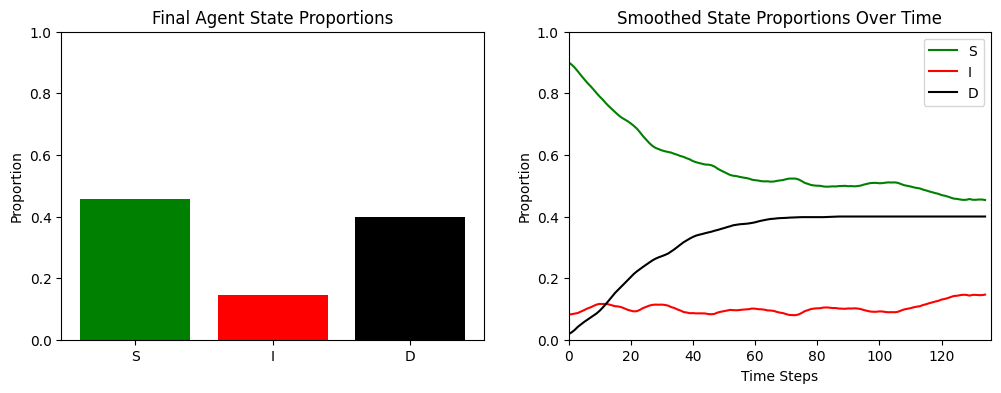

,step,dead_proportion,max_infected,auc_infected,avg_viral_age,avg_immunity,non_vul_prop_dead
0,134.0,0.4,0.152,13.821,7.012,0.696,0.427015


In [5]:
simulation_results = pd.DataFrame(columns=["step", "dead_proportion", "max_infected", "auc_infected", "avg_viral_age", "avg_immunity","non_vul_prop_dead"])

simulation = Simulation(grid_size=25, num_agents=500, agent_class = FullAgent, init_infected_proportion = 0.1,
                 proportion_vulnerable=0.1, vul_penalty = 0.2,
                 infection_prob=0.25, recovery_time=30, death_prob=0.1,
                 vax_vulnerable=False,
                 vax_all=False,
                 vax_effect = 0.7,
                 viral_age_effect = 0.1,
                 immune_adaptation_effect = 0.1,
                 plot=True)
simulation.run(500)  # Run for 20 iterations
# simulation.plot_hist()
results = simulation.generate_simulation_report()
simulation_results.loc[len(simulation_results)] = results
# simulation_results = pd.concat([simulation_results, results], ignore_index=True)
simulation_results

In [6]:
results[1]

np.float64(0.4)

# Bayesian Optimization with Parallelization (and n_trials)

## Parameters

In [13]:
# --- Fixed Parameters ---
grid_size = 25
num_agents = 500
init_infected_proportion = 0.1
proportion_vulnerable = 0.1
recovery_time = 30

fixed_infection_prob = 0.25
fixed_immune_adaptation_effect = 0.1
fixed_vul_penalty = 2

# --- Search Space (reduced) ---
space = [
    Real(0.01, 0.9, name='death_prob'),
    Real(0.1, 0.9, name='vax_effect'),
    Real(0.1, 0.9, name='viral_age_effect')]

## Functions

In [14]:
# --- Averaged Simulation Runner ---
def average_simulation_metrics(params, n_trials, inner_workers=None):
    """Runs simulation n_trials times in parallel and returns averaged metrics."""
    if n_trials < 1:
        raise ValueError("n_trials must be at least 1.")

    inner_workers = inner_workers or min(cpu_count(), n_trials)

    trial_results = Parallel(n_jobs=inner_workers, backend="threading")(
        delayed(run_simulation_for_params)(params) for _ in range(n_trials)
    )

    avg_result = {}
    keys = trial_results[0].keys()

    for key in keys:
        values = [res[key] for res in trial_results]
        if isinstance(values[0], (float, int)):
            avg_result[key] = np.mean(values)
        else:
            avg_result[key] = values[0]  # Preserve params or other non-numeric values

    return avg_result



def run_simulation_for_params(params):
    """Evaluate harm caused (or prevented) by vaccinating all vs vulnerable-only."""
    results = {}
    for vax_all in [True, False]:
        simulation = Simulation(
            grid_size=grid_size,
            num_agents=num_agents,
            agent_class=FullAgent,
            init_infected_proportion=init_infected_proportion,
            proportion_vulnerable=proportion_vulnerable,
            vul_penalty=fixed_vul_penalty,
            infection_prob=fixed_infection_prob,
            recovery_time=recovery_time,
            death_prob=params[0],
            vax_vulnerable=True,
            vax_all=vax_all,
            vax_effect=params[1],
            viral_age_effect=params[2],
            immune_adaptation_effect=fixed_immune_adaptation_effect,
            plot=False
        )
        simulation.run()
        report = simulation.generate_simulation_report()
        results[vax_all] = {
            'steps': report[0],
            'deaths': report[1],
            'auc_infected': report[3],
            'avg_viral_age': report[4],
            'avg_immunity': report[5],
            'non_vul_proportion_dead': report[6],
        }

    harm = results[True]['deaths'] - results[False]['deaths']
    auc_diff = results[True]['auc_infected'] - results[False]['auc_infected']

    return {
        'harm': -harm,
        'deaths_vax': results[True]['deaths'],
        'deaths_no_vax': results[False]['deaths'],
        'steps_vax': results[True]['steps'],
        'steps_no_vax': results[False]['steps'],
        'auc_vax': results[True]['auc_infected'],
        'auc_no_vax': results[False]['auc_infected'],
        'delta_auc': auc_diff,
        'non_vul_proportion_dead_delta': results[True]['non_vul_proportion_dead'] - results[False]['non_vul_proportion_dead'],
        'viral_age_delta': results[True]['avg_viral_age'] - results[False]['avg_viral_age'],
        'immunity_delta': results[True]['avg_immunity'] - results[False]['avg_immunity'],
        'params': params
    }


# --- Parallel Evaluation ---
def parallel_objective(params_batch, progress_desc="Running Batch", num_workers=None, n_trials=5):
    """Parallelized wrapper for simulation trials per parameter set."""
    num_workers = num_workers or cpu_count()
    print(f"Using {num_workers} workers")

    # results = Parallel(n_jobs=num_workers)(
    #     delayed(average_simulation_metrics)(params, n_trials)
    #     for params in tqdm(params_batch, desc=progress_desc)
    # )

    results = Parallel(n_jobs=num_workers)(
    delayed(average_simulation_metrics)(params, n_trials) for params in tqdm(params_batch, desc=progress_desc)
)

    return results


# --- BO Runner ---
def run_bayesian_optimization(
    n_calls=300,
    n_initial_points=50,
    parallel_batch_size=50,
    num_workers=None,
    n_trials=5
):
    print(f"\n--- Running BO with n_trials={n_trials} for fixed immune_adaptation_effect={fixed_immune_adaptation_effect}, infection_prob={fixed_infection_prob}, vul_penalty={fixed_vul_penalty} ---")
    results_list = []

    def batch_objective(params_batch, desc):
        batch_results = parallel_objective(params_batch, desc, num_workers, n_trials=n_trials)
        for p, res in zip(params_batch, batch_results):
            results_list.append({
                'death_prob': p[0],
                'vul_penalty': fixed_vul_penalty,
                'vax_effect': p[1],
                'viral_age_effect': p[2],
                'immune_adaptation_effect': fixed_immune_adaptation_effect,
                'infection_prob': fixed_infection_prob,
                'vax_harm_score': res['harm'],
                'deaths_vax': res['deaths_vax'],
                'deaths_no_vax': res['deaths_no_vax'],
                'steps_vax': res['steps_vax'],
                'steps_no_vax': res['steps_no_vax'],
                'auc_vax': res['auc_vax'],
                'auc_no_vax': res['auc_no_vax'],
                'delta_auc': res['delta_auc'],
                'non_vul_proportion_dead_delta': res['non_vul_proportion_dead_delta'],
                'viral_age_delta': res['viral_age_delta'],
                'immunity_delta': res['immunity_delta'],
            })
        return [r['harm'] for r in batch_results]

    opt = Optimizer(dimensions=space, base_estimator="GP", acq_func="gp_hedge", random_state=42)

    initial_params = opt.ask(n_initial_points)
    batch_objective(initial_params, desc="Initial Random Sampling")
    opt.tell(initial_params, [r['vax_harm_score'] for r in results_list])

    num_batches = (n_calls - n_initial_points) // parallel_batch_size
    for i in tqdm(range(num_batches), desc="Bayesian Optimization Progress"):
        next_params = opt.ask(parallel_batch_size)
        batch_results = batch_objective(next_params, desc=f"Batch {i+1}/{num_batches}")
        opt.tell(next_params, batch_results)

    df_results = pd.DataFrame(results_list)
    df_results.to_csv(dump_path + 'bo_results_fixed_params.csv', index=False)
    print("Bayesian Optimization complete! Results saved to 'bo_results_fixed_params.csv'.")

    vax_hurts_df = get_vax_hurts_region(df_results)
    plot_3d_vax_hurts(df_results)
    plotly_3d_vax_hurts(df_results)
    return df_results, vax_hurts_df


# --- Harm Region Analysis ---
def get_vax_hurts_region(df_results):
    df_results['actual_diff'] = -df_results['vax_harm_score']
    hurts = df_results[df_results['actual_diff'] > 0]
    print(f"\nFound {len(hurts)} parameter sets where vaccination increased deaths.")
    hurts.to_csv(dump_path + 'vax_hurts_region.csv', index=False)
    return hurts


# --- Plotting ---
def plot_3d_vax_hurts(df_results, filepath=None):
    df_results['actual_diff'] = -df_results['vax_harm_score']
    hurts_df = df_results[df_results['actual_diff'] > 0]

    if hurts_df.empty:
        print("No harmful vaccination outcomes found. Skipping 3D plot.")
        return

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    x, y, z = hurts_df['death_prob'], hurts_df['vax_effect'], hurts_df['viral_age_effect']
    harm = hurts_df['actual_diff']
    norm = mcolors.Normalize(vmin=harm.min(), vmax=harm.max())
    colors = cm.Reds(norm(harm))

    ax.scatter(x, y, z, c=colors, marker='o', alpha=0.9)
    ax.set_xlabel('Death Probability')
    ax.set_ylabel('Vaccine Effectiveness')
    ax.set_zlabel('Viral Age Effect')
    ax.set_title('3D Region Where Vaccination Increased Deaths')

    mappable = cm.ScalarMappable(norm=norm, cmap=cm.Reds)
    mappable.set_array(harm)
    cbar = plt.colorbar(mappable, ax=ax, pad=0.1)
    cbar.set_label('Vaccination Harm (Δ deaths)')

    plt.tight_layout()
    filepath = filepath or dump_path + "vax_hurts_3d_plot.png"
    plt.savefig(filepath, dpi=300)
    print(f"Plot saved to {filepath}")
    plt.show()


def plotly_3d_vax_hurts(df_results, output_html=None):
    df_results['actual_diff'] = -df_results['vax_harm_score']
    hurts_df = df_results[df_results['actual_diff'] > 0]

    if hurts_df.empty:
        print("No harmful vaccination outcomes found. Skipping Plotly plot.")
        return

    fig = px.scatter_3d(
        hurts_df,
        x='death_prob',
        y='vax_effect',
        z='viral_age_effect',
        color='actual_diff',
        color_continuous_scale='Reds',
        title='Interactive 3D: Where Vaccination Increased Deaths',
        labels={'actual_diff': 'Vax Harm (Δ deaths)'},
        opacity=0.8
    )

    fig.update_traces(marker=dict(size=5))
    output_html = output_html or dump_path + "interactive_vax_hurts_plot.html"
    fig.write_html(output_html)
    print(f"Interactive 3D plot saved to '{output_html}'")
    fig.show()


In [15]:
def reevaluate_top_harmful_params(
    vax_hurts_df,
    top_n=25,
    repeats=100,
    num_workers=None
):
    print(f"\n--- Reevaluating top {top_n} harmful parameter sets with {repeats} simulations each ---")

    top_params_df = vax_hurts_df.sort_values('actual_diff', ascending=False).head(top_n).reset_index(drop=True)
    aggregate_results = []

    def simulate_once(param_row):
        sim_vax = Simulation(
            grid_size=grid_size,
            num_agents=num_agents,
            agent_class=FullAgent,
            init_infected_proportion=init_infected_proportion,
            proportion_vulnerable=proportion_vulnerable,
            vul_penalty=fixed_vul_penalty,
            infection_prob=fixed_infection_prob,
            recovery_time=recovery_time,
            death_prob=param_row['death_prob'],
            vax_vulnerable=True,
            vax_all=True,
            vax_effect=param_row['vax_effect'],
            viral_age_effect=param_row['viral_age_effect'],
            immune_adaptation_effect=fixed_immune_adaptation_effect,
            plot=False
        )
        sim_vax.run()
        report_vax = sim_vax.generate_simulation_report()

        sim_novax = Simulation(
            grid_size=grid_size,
            num_agents=num_agents,
            agent_class=FullAgent,
            init_infected_proportion=init_infected_proportion,
            proportion_vulnerable=proportion_vulnerable,
            vul_penalty=fixed_vul_penalty,
            infection_prob=fixed_infection_prob,
            recovery_time=recovery_time,
            death_prob=param_row['death_prob'],
            vax_vulnerable=True,
            vax_all=False,
            vax_effect=param_row['vax_effect'],
            viral_age_effect=param_row['viral_age_effect'],
            immune_adaptation_effect=fixed_immune_adaptation_effect,
            plot=False
        )
        sim_novax.run()
        report_novax = sim_novax.generate_simulation_report()

        return (
            report_novax[1],  # deaths no vax
            report_vax[1],    # deaths vax
            report_vax[1] - report_novax[1],  # death harm
            report_novax[0],  # steps no vax
            report_vax[0],    # steps vax
            report_novax[3],  # auc no vax
            report_vax[3],    # auc vax
            report_vax[3] - report_novax[3],  # auc harm
            report_vax[6] - report_novax[6],  # non-vul dead delta
            report_vax[4] - report_novax[4],  # viral age delta
            report_vax[5] - report_novax[5],  # immunity delta
        )

    for i, row in tqdm(top_params_df.iterrows(), total=len(top_params_df), desc="Top Harmful Points"):
        param_row = row.copy()

        repeated_results = Parallel(n_jobs=num_workers)(
            delayed(simulate_once)(param_row) for _ in range(repeats)
        )

        assert len(repeated_results[0]) == 11, "simulate_once should return 11 values."

        deaths_no_vax = [r[0] for r in repeated_results]
        deaths_vax = [r[1] for r in repeated_results]
        death_diffs = [r[2] for r in repeated_results]
        steps_no_vax = [r[3] for r in repeated_results]
        steps_vax = [r[4] for r in repeated_results]
        auc_no_vax = [r[5] for r in repeated_results]
        auc_vax = [r[6] for r in repeated_results]
        auc_diffs = [r[7] for r in repeated_results]
        non_vul_dead_deltas = [r[8] for r in repeated_results]
        viral_age_deltas = [r[9] for r in repeated_results]
        immunity_deltas = [r[10] for r in repeated_results]

        aggregate_results.append({
            'index': i,
            'death_prob': row['death_prob'],
            'vax_effect': row['vax_effect'],
            'viral_age_effect': row['viral_age_effect'],
            'vax_harm_score': np.mean(death_diffs),
            'mean_vax_harm': np.mean(death_diffs),
            'median_vax_harm': np.median(death_diffs),
            'max_vax_harm': np.max(death_diffs),
            'min_vax_harm': np.min(death_diffs),
            'std_vax_harm': np.std(death_diffs),

            'mean_steps_vax': np.mean(steps_vax),
            'mean_steps_no_vax': np.mean(steps_no_vax),

            'mean_auc_vax': np.mean(auc_vax),
            'mean_auc_no_vax': np.mean(auc_no_vax),
            'mean_delta_auc': np.mean(auc_diffs),
            'std_delta_auc': np.std(auc_diffs),

            'mean_non_vul_proportion_dead_delta': np.mean(non_vul_dead_deltas),
            'std_non_vul_proportion_dead_delta': np.std(non_vul_dead_deltas),

            'viral_age_delta': np.mean(viral_age_deltas),
            'immunity_delta': np.mean(immunity_deltas),
            'std_viral_age_delta': np.std(viral_age_deltas),
            'std_immunity_delta': np.std(immunity_deltas),
        })

    result_df = pd.DataFrame(aggregate_results)
    result_df.to_csv(dump_path + "top_harmful_param_reevaluation.csv", index=False)
    print("Saved reevaluation results to 'top_harmful_param_reevaluation.csv'")

    print("\nGenerating 3D visualizations of aggregated harm...")

    result_df.rename(columns={'mean_vax_harm': 'actual_diff'}, inplace=True)

    plot_3d_vax_hurts(result_df, filepath=dump_path + "reevaluated_harm_3d_plot.png")
    plotly_3d_vax_hurts(result_df, output_html=dump_path + "reevaluated_harm_3d_plot.html")

    return result_df


## Run Optimization

In [ ]:
# --- Run Optimization ---
%%time
if __name__ == "__main__":
    df_results, vax_hurts_df = run_bayesian_optimization(
        n_calls=1000,
        n_initial_points=250,
        parallel_batch_size=100,
        num_workers=None,  # Use all cores
        n_trials=50
    )


--- Running BO with n_trials=50 for fixed immune_adaptation_effect=0.1, infection_prob=0.25, vul_penalty=2 ---
Using 8 workers


Initial Random Sampling: 100%|██████████| 250/250 [4:26:22<00:00, 63.93s/it]


In [ ]:
vax_hurts_df.head(10)

## Run Sanity Check

In [ ]:
%%time
df = pd.read_csv(dump_path + 'vax_hurts_region.csv')
averaged_hurts_results_df = reevaluate_top_harmful_params(df, top_n=int(len(df)/2), repeats=200, num_workers=None)
averaged_hurts_results_df.head()

## Include No Vaccination

In [ ]:
def reevaluate_top_harmful_params_woutvax(
    vax_hurts_df,
    top_n=25,
    repeats=100,
    num_workers=None
):
    print(f"\n--- Reevaluating top {top_n} harmful parameter sets with {repeats} simulations each ---")

    top_params_df = vax_hurts_df.sort_values('actual_diff', ascending=False).head(top_n).reset_index(drop=True)
    aggregate_results = []

    def simulate_once(param_row):
        # No vaccination
        sim_novax = Simulation(
            grid_size=grid_size,
            num_agents=num_agents,
            agent_class=FullAgent,
            init_infected_proportion=init_infected_proportion,
            proportion_vulnerable=proportion_vulnerable,
            vul_penalty=fixed_vul_penalty,
            infection_prob=fixed_infection_prob,
            recovery_time=recovery_time,
            death_prob=param_row['death_prob'],
            vax_vulnerable=False,
            vax_all=False,
            vax_effect=param_row['vax_effect'],
            viral_age_effect=param_row['viral_age_effect'],
            immune_adaptation_effect=fixed_immune_adaptation_effect,
            plot=False
        )
        sim_novax.run()
        report_novax = sim_novax.generate_simulation_report()

        # Vaccinate only vulnerable
        sim_vul = Simulation(
            grid_size=grid_size,
            num_agents=num_agents,
            agent_class=FullAgent,
            init_infected_proportion=init_infected_proportion,
            proportion_vulnerable=proportion_vulnerable,
            vul_penalty=fixed_vul_penalty,
            infection_prob=fixed_infection_prob,
            recovery_time=recovery_time,
            death_prob=param_row['death_prob'],
            vax_vulnerable=True,
            vax_all=False,
            vax_effect=param_row['vax_effect'],
            viral_age_effect=param_row['viral_age_effect'],
            immune_adaptation_effect=fixed_immune_adaptation_effect,
            plot=False
        )
        sim_vul.run()
        report_vul = sim_vul.generate_simulation_report()

        # Vaccinate all
        sim_all = Simulation(
            grid_size=grid_size,
            num_agents=num_agents,
            agent_class=FullAgent,
            init_infected_proportion=init_infected_proportion,
            proportion_vulnerable=proportion_vulnerable,
            vul_penalty=fixed_vul_penalty,
            infection_prob=fixed_infection_prob,
            recovery_time=recovery_time,
            death_prob=param_row['death_prob'],
            vax_vulnerable=True,
            vax_all=True,
            vax_effect=param_row['vax_effect'],
            viral_age_effect=param_row['viral_age_effect'],
            immune_adaptation_effect=fixed_immune_adaptation_effect,
            plot=False
        )
        sim_all.run()
        report_all = sim_all.generate_simulation_report()

        return (
            report_novax,  # 0
            report_vul,    # 1
            report_all     # 2
        )

    for i, row in tqdm(top_params_df.iterrows(), total=len(top_params_df), desc="Top Harmful Points"):
        param_row = row.copy()

        repeated_results = Parallel(n_jobs=num_workers)(
            delayed(simulate_once)(param_row) for _ in range(repeats)
        )

        deaths_novax = [r[0][1] for r in repeated_results]
        deaths_vul = [r[1][1] for r in repeated_results]
        deaths_all = [r[2][1] for r in repeated_results]

        death_diff_vul = [r[1][1] - r[0][1] for r in repeated_results]
        death_diff_all = [r[2][1] - r[0][1] for r in repeated_results]

        aggregate_results.append({
            'index': i,
            'death_prob': row['death_prob'],
            'vax_effect': row['vax_effect'],
            'viral_age_effect': row['viral_age_effect'],

            'mean_deaths_novax': np.mean(deaths_novax),
            'mean_deaths_vul': np.mean(deaths_vul),
            'mean_deaths_all': np.mean(deaths_all),

            'mean_vul_diff': np.mean(death_diff_vul),
            'mean_all_diff': np.mean(death_diff_all),
            'std_vul_diff': np.std(death_diff_vul),
            'std_all_diff': np.std(death_diff_all),
        })

    result_df = pd.DataFrame(aggregate_results)
    result_df.to_csv(dump_path + "top_harmful_param_reevaluation.csv", index=False)
    print("Saved reevaluation results to 'top_harmful_param_reevaluation.csv'")

    print("\nGenerating 3D visualizations of aggregated harm...")
    result_df.rename(columns={'mean_all_diff': 'actual_diff'}, inplace=True)
    plot_3d_vax_hurts(result_df, filepath=dump_path + "reevaluated_harm_3d_plot.png")
    plotly_3d_vax_hurts(result_df, output_html=dump_path + "reevaluated_harm_3d_plot.html")

    return result_df


In [ ]:
%%time
df = pd.read_csv(dump_path + 'vax_hurts_region.csv')
averaged_hurts_results_df = reevaluate_top_harmful_params_woutvax(df, top_n=int(len(df)/2), repeats=200, num_workers=None)
averaged_hurts_results_df.head()